# Overview
This script takes in an image and returns a list of coordinates of pixels which the centre of the robot should visit.

Variables which depend on the robot and setting: 
radius, colour channels

In [32]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy import stats
!pip install imutils
import imutils
from math import pi

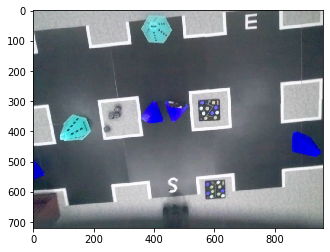

In [33]:
img = cv2.imread("drone_images/0.jpg", cv2.IMREAD_UNCHANGED)
plt.imshow(img)

[[653.          1.4835298]]
[[594.          1.4835298]]
[[605.          1.4835298]]
[[-488.          3.054326]]
[[146.          1.4660766]]
[[-163.          2.984513]]
[[135.          1.4660766]]
[[-498.          3.054326]]
[[150.          1.4660766]]
[[442.          1.4660766]]
[[608.          1.4660766]]
[[-637.           3.0892327]]
[[70.         1.4660766]]
[[448.          1.4660766]]
[[446.          1.4835298]]
[[138.          1.4660766]]
[[603.          1.5009831]]
[[651.          1.5009831]]
[[68.         1.4835298]]
[[311.          1.4835298]]
[[-236.           3.0019662]]
[[318.          1.4660766]]
[[-627.           3.0892327]]
[[324.          1.4660766]]
[84.22479]


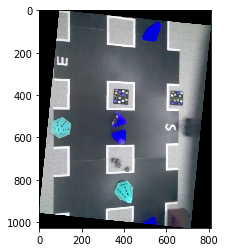

In [37]:
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_img,50,150,apertureSize = 3)
lines = cv2.HoughLines(edges,1,np.pi/180,100)

angles = []

for line in lines:
    print(line)
    for rho,theta in line:
        angles.append(round(theta, 2))
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(gray_img,(x1,y1),(x2,y2),255,2)

plt.imshow(gray_img)
mode_angle = stats.mode(np.array(angles))[0]
mode_angle = mode_angle * 180 / pi
print(mode_angle)
img = imutils.rotate_bound(img, -mode_angle)
plt.imshow(img)

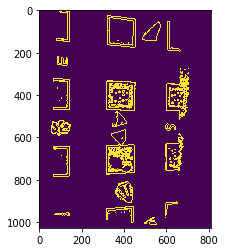

In [38]:
img_contours = np.zeros(img.shape[:2])
def drawcontour(channel):
    img_chan = img[:,:,channel]
    thresh = 200
    ret,thresh_img = cv2.threshold(img_chan, thresh, 255, cv2.THRESH_BINARY)
    contours = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    cv2.drawContours(img_contours, contours, -1, 1, 3)

#draw contours based on all three channels
drawcontour(0)
drawcontour(1)
drawcontour(2)
plt.imshow(img_contours)

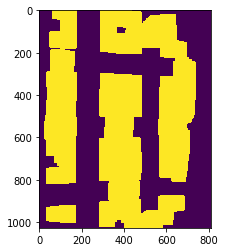

In [44]:
def expand(bitmap, radius):
    height = bitmap.shape[0]
    width = bitmap.shape[1]
    newbitmap = copy.deepcopy(bitmap)
    for x in range(height):
        for y in range(width):
            if bitmap[x,y]==0: continue
            newbitmap[max(x-radius,0):min(x+radius,height), max(y-radius,0):min(y+radius,width)] = 1
    return newbitmap
plt.imshow(expand(img_contours, 32))

In [40]:
import queue
dx = (-1,0,0,1)
dy = (0,-1,1,0)

def genDistFromWalls(img_expanded):
    xmax,ymax = img_expanded.shape
    
    dist = np.full(img_expanded.shape,-1)
    prev = np.full(img_expanded.shape+(2,),-1)
    
    q = queue.Queue()
    
    for x in range(xmax):
        for y in range(ymax):
            if img_expanded[x][y] == 1: #Colour of wall
                dist[x][y] = 0
                q.put((x,y))
    
    while not q.empty():
        x,y = q.get()
        for i in range(4):
            nx,ny = x+dx[i], y+dy[i]
            if nx<0 or nx>=xmax or ny<0 or ny>=ymax:
                continue
            if dist[nx][ny] != -1:
                continue

            dist[nx][ny] = dist[x][y]+1
            prev[nx][ny] = (x,y)
            q.put((nx,ny))
    
    return dist
    
def bfs(img_expanded, start, end):
    xmax,ymax = img_expanded.shape
    xstart,ystart = start
    xend,yend = end
    assert(img_expanded[xstart][ystart] == 0 and img_expanded[xend][yend] == 0)
    
    dist = np.full(img_expanded.shape,-1)
    prev = np.full(img_expanded.shape+(2,),-1)
    
    q = queue.Queue()
    dist[xstart][ystart] = 0
    q.put((xstart,ystart))
    
    while not q.empty():
        x,y = q.get()
        for i in range(4):
            nx,ny = x+dx[i], y+dy[i]
            if nx<0 or nx>=xmax or ny<0 or ny>=ymax:
                continue
            if img_expanded[nx][ny] != img_expanded[xstart][ystart]:
                continue
            if dist[nx][ny] != -1:
                continue

            dist[nx][ny] = dist[x][y]+1
            prev[nx][ny] = (x,y)
            q.put((nx,ny))
    
    path = [(xend,yend)]
    while path[-1] != (xstart,ystart):
        if path[-1] == (-1,-1):
            print("No path found!")
            break
        x,y = path[-1]
        path.append(tuple(prev[x][y]))
    path.reverse()

    return dist,prev,path

def dijkstra(img_expanded, start, end, edge_weight=lambda x:1000/x):
    xmax,ymax = img_expanded.shape
    xstart,ystart = start
    xend,yend = end
    assert(img_expanded[xstart][ystart] == 0 and img_expanded[xend][yend] == 0)
    
    dist_walls=genDistFromWalls(img_expanded)
    
    dist = np.full(img_expanded.shape,-1.0)
    prev = np.full(img_expanded.shape+(2,),-1)
    
    q = queue.PriorityQueue()
    dist[xstart][ystart] = 0
    q.put((0,xstart,ystart))
    
    while not q.empty():
        d,x,y = q.get()
        #print(x,y)
        if d != dist[x][y]:
            #print(dist[x][y],type(dist[x][y]))
            #print(d,type(d))
            continue
        for i in range(4):
            nx,ny = x+dx[i], y+dy[i]
            
            if nx<0 or nx>=xmax or ny<0 or ny>=ymax:
                continue
            if img_expanded[nx][ny] != img_expanded[xstart][ystart]:
                continue
            
            nd = d+1+edge_weight(dist_walls[nx][ny])
            
            if dist[nx][ny] == -1 or dist[nx][ny] > nd:
                dist[nx][ny] = nd
                prev[nx][ny] = (x,y)
                q.put((nd,nx,ny))
    
    path = [(xend,yend)]
    while path[-1] != (xstart,ystart):
        if path[-1] == (-1,-1):
            print("No path found!")
            break
        x,y = path[-1]
        path.append(tuple(prev[x][y]))
    path.reverse()

    return dist,prev,path

def plot_path(img_expanded, start, end, path):
    xstart,ystart = start
    xend,yend = end
    
    plt.imshow(dist, cmap='hot', interpolation='nearest')
    plt.text(ystart,xstart,'S',color='g',bbox=dict(fill=False, edgecolor='green', linewidth=2))
    plt.text(yend,xend,'E',color='b',bbox=dict(fill=False, edgecolor='blue', linewidth=2))

    x,y = list(zip(*path))
    plt.scatter(y,x,s=1,c='purple')

    plt.show()

In [46]:
expanded = expand(img_contours, 32)

start = (900, 100)
end = (860, 600)

print(expanded[start[0]][start[1]])
print("start:\t",start)
print("end:\t",end)

0.0
start:	 (900, 100)
end:	 (860, 600)


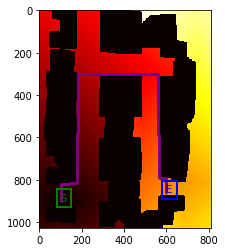

In [47]:
dist,prev,path = dijkstra(expanded, start, end, lambda x:0)
plot_path(expanded,start,end,path)

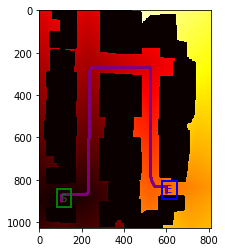

In [48]:
dist,prev,path = dijkstra(expanded, start, end, lambda x:10/x)
plot_path(expanded,start,end,path)

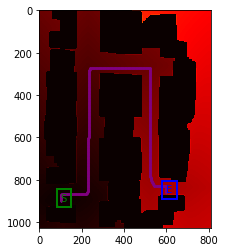

In [49]:
from math import log
dist,prev,path = dijkstra(expanded, start, end, lambda x:10/(0.01+log(x)))
plot_path(expanded,start,end,path)

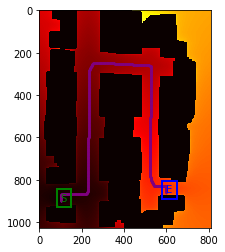

In [50]:
dist,prev,path = dijkstra(expanded, start, end, lambda x:1000/x)
plot_path(expanded,start,end,path)

# Testing
Possible idea: For each pixel, find the distance to the nearest wall/obstacle. The middle of each road is (kind of) a local maxima. 

In [11]:
dist_walls=genDistFromWalls(expanded)

In [12]:
newdist = np.clip(dist,-1,100)
from scipy.signal import argrelextrema
ind = argrelextrema(newdist,np.greater_equal)

In [13]:
xmax,ymax = expanded.shape
for x in range(xmax):
    for y in range(ymax):
        neighbours = []
        for i in range(4):
            nx,ny = x+dx[i], y+dy[i]
            if nx<0 or nx>=xmax or ny<0 or ny>=ymax:
                continue
            neighbours.append(dist[nx][ny])
        if sum(dist[x][y]>=d for d in neighbours)>=3:
            newdist[x][y]=1000

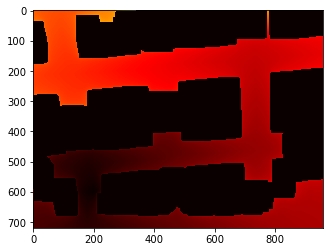

In [14]:
plt.imshow(dist, cmap='hot', interpolation='nearest')